# UMAP with Cached/Computed SPI Features
Uses the provided code to build (or load) SPI/SPI-SPI features and plot a UMAP embedding.

In [106]:
import logging, warnings
import numpy as np, pandas as pd
from pathlib import Path
from scipy.stats import spearmanr, ConstantInputWarning
from tqdm import tqdm
from umap import UMAP
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

from src.utils import iter_dataset_dirs, load_json
from src.plot_style import apply_plot_style

apply_plot_style()
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
warnings.simplefilter("ignore", ConstantInputWarning)


#### **[OLD] Helpers for recomputing features directly in notebook from raw data**

In [107]:
def build_index(mode="full"):
    rows = []
    for ds_dir in iter_dataset_dirs(mode):
        meta = load_json(ds_dir / "meta.json")
        rows.append({
            "dataset_path": Path(ds_dir),
            "mts_class": meta["mts_class"],
            "variant": (meta.get("variant") or {}).get("name", "") if isinstance(meta.get("variant"), dict) else (meta.get("variant") or ""),
            "M": meta.get("M"), "T": meta.get("T"),
            "instance": meta.get("instance_index"),
            "spis": meta["pyspi"]["spis"],
        })
    return pd.DataFrame(rows)

def _zscore(vec):
    vec = np.asarray(vec, float)
    std = vec.std()
    if std < 1e-12 or not np.isfinite(std):
        return np.zeros_like(vec)
    return (vec - vec.mean()) / std

def _spi_vectors(spi_names, directed_flags, ds_dir):
    with np.load(Path(ds_dir) / "spi_mpis.npz") as npz:
        for name, directed in zip(spi_names, directed_flags):
            mat = np.asarray(npz[name], float)
            if not directed:
                mat = 0.5 * (mat + mat.T)
            upper = mat[np.triu_indices(mat.shape[0], k=1)]
            full = mat.reshape(-1)
            yield (upper, full, directed)

def spi_spi_features(ds_row, feature_space="spi-spi"):
    spi_names = [s["name"] for s in ds_row["spis"]]
    directed_flags = [s.get("directed", False) for s in ds_row["spis"]]
    vectors = list(_spi_vectors(spi_names, directed_flags, ds_row["dataset_path"]))

    if feature_space == "spi-spi":
        n = len(vectors)
        corr = np.eye(n, dtype=np.float32)
        for i in range(n):
            for j in range(i + 1, n):
                vi_u, vi_f, di = vectors[i]
                vj_u, vj_f, dj = vectors[j]
                vi = vi_u if (not di and not dj) else vi_f
                vj = vj_u if (not di and not dj) else vj_f
                r = spearmanr(_zscore(vi), _zscore(vj)).correlation
                corr[i, j] = corr[j, i] = 0.0 if not np.isfinite(r) else r
        iu = np.triu_indices(n, k=1)
        return corr[iu]

    if feature_space == "spi":
        blocks = []
        for (upper, full, directed) in vectors:
            vec = upper if not directed else full
            blocks.append(_zscore(vec))
        return np.concatenate(blocks).astype(np.float32)

    raise ValueError("feature_space must be 'spi-spi' or 'spi'")

def load_features(mode: str, feature_space: str, limit: int = None, use_cache: bool = True, cache_path: Path = Path("analysis/features.npz")):
    if use_cache and cache_path.exists():
        data = np.load(cache_path, allow_pickle=True)
        X = data['X']
        meta_df = pd.DataFrame({
            'mts_class': data['mts_class'],
            'variant': data['variant'],
            'M': data['M'],
            'T': data['T'],
            'dataset_path': data['dataset_path'],
        })
        spi_order = list(data['spi_order'])
        pairs = list(data['pairs'])
        logging.info("Loaded cached features from %s", cache_path)
        return X, meta_df, spi_order, pairs
    
    else:
        meta_df = build_index(mode)
        if limit:
            meta_df = meta_df.iloc[:limit].reset_index(drop=True)
        features = []
        for _, row in tqdm(meta_df.iterrows(), total=len(meta_df), desc=f"features-{feature_space}"):
            features.append(spi_spi_features(row, feature_space=feature_space))
        X = np.vstack(features)
        logging.info("feature matrix shape: %s", X.shape)
        return X, meta_df, spi_order, pairs

#### Load or compute features

##### **v1** - `test_features.py` + feature matrix selection

In [149]:
def load_features_from_cache(cache_path):
    data = np.load(cache_path, allow_pickle=True)
    X = data["X"]
    meta_df = pd.DataFrame({
        "mts_class": data["mts_class"],
        "variant": data["variant"],
        "M": data["M"],
        "T": data["T"],
        "dataset_path": data["dataset_path"],
    })
    spi_order = list(data.get("spi_order", []))
    pairs = list(data.get("pairs", []))
    return X, meta_df, spi_order, pairs

In [150]:
X, meta_df, spi_order, pairs = load_features_from_cache("analysis/features_full_all.npz")

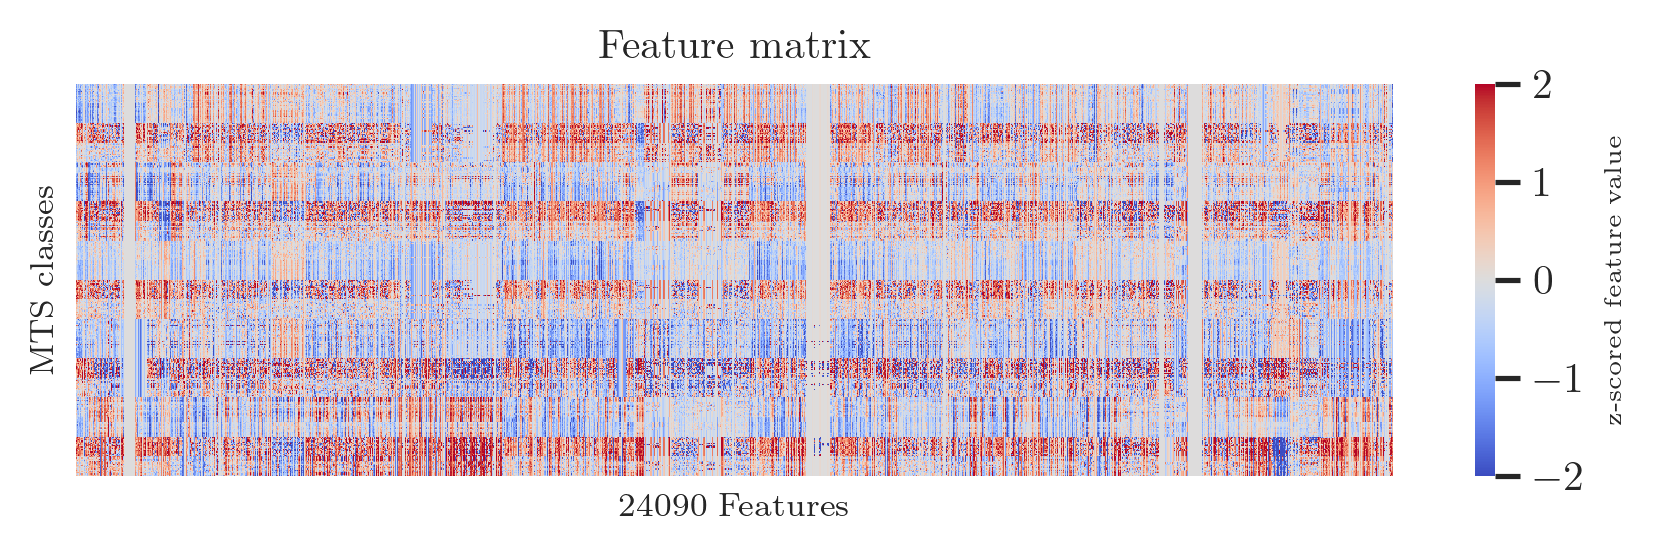

In [ ]:
selected_classes = ["GaussianNoise", "CauchyNoise", "VAR(1)", "Kuramoto", "CML"] # specify desired classes or leave empty for all
noise_mask = meta_df["mts_class"].isin(selected_classes)
X_selected = X[noise_mask] if selected_classes else X            
meta_selected = meta_df[noise_mask]   

# Z-normalize each feature (column) across the selected noise datasets
col_means = X_selected.mean(axis=0)
col_stds = X_selected.std(axis=0)
Xz = (X_selected - col_means) / (col_stds + 1e-9)  # avoid div-by-zero

fig, ax = plt.subplots(figsize=(6, 2), dpi=300)
sns.heatmap(Xz, cmap="coolwarm", cbar=True, ax=ax, vmin=-2, vmax=2)  #cbar_kws={"shrink": 0.8},
ax.collections[0].colorbar.set_label("z-scored feature value", fontsize=6)
ax.set_xlabel(f"{Xz.shape[1]} Features", fontsize=8)
ax.set_ylabel("MTS classes", fontsize=8)
ax.set_xticklabels(""), ax.set_yticklabels("")
ax.set_xticks([]), ax.set_yticks([])
ax.set_title(f"Feature matrix", fontsize=10)
plt.tight_layout()
plt.show()

###### check for 0/NaN feature cols

In [61]:
eps = 1e-8              # “near zero” cutoff; relax to 1e-6 if you want
dom_thresh = 0.99       # flag features that are near zero in ≥99% of datasets

abs_X = np.abs(X)
frac_near_zero = (abs_X < eps).mean(axis=0)      # per-column fraction near zero
all_near_zero = frac_near_zero == 1.0            # exactly zero (within eps) everywhere
dom_near_zero = frac_near_zero >= dom_thresh     # almost always zero

summary = pd.DataFrame({
    "feature_idx": np.arange(X.shape[1]),
    "min": X.min(axis=0),
    "max": X.max(axis=0),
    "frac_near_zero": frac_near_zero,
    "all_near_zero": all_near_zero,
    "dom_near_zero": dom_near_zero,
})
summary_near_zero = summary[summary["dom_near_zero"]].sort_values("frac_near_zero", ascending=False)
summary_near_zero.head()

,feature_idx,min,max,frac_near_zero,all_near_zero,dom_near_zero
42,42,0.0,0.0,1.0,True,True
17624,17624,0.0,0.0,1.0,True,True
17626,17626,0.0,0.0,1.0,True,True
17627,17627,0.0,0.0,1.0,True,True
17628,17628,0.0,0.0,1.0,True,True


In [62]:
# Example if pairs aligns 1:1 with columns
labels = [f"{a} vs {b}" for a, b in pairs]  # adjust to your actual mapping
summary["label"] = labels
summary_near_zero = summary[summary["dom_near_zero"]].sort_values("frac_near_zero", ascending=False)
summary_near_zero[["feature_idx", "label", "frac_near_zero", "min", "max"]].head(20)


,feature_idx,label,frac_near_zero,min,max
42,42,cov_EmpiricalCovariance vs bary_euclidean_mean,1.0,0.0,0.0
17624,17624,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17626,17626,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17627,17627,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17628,17628,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17629,17629,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17630,17630,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17688,17688,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17689,17689,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0
17690,17690,psi_multitaper_mean_fs-1_fmin-0-25_fmax-0-5 vs...,1.0,0.0,0.0


##### **v1.1** - `case_2` - `test_features.py`:

In [247]:
def load_features_from_cache(cache_path):
    data = np.load(cache_path, allow_pickle=True)
    X = data["X"]
    meta_df = pd.DataFrame({
        "mts_class": data["mts_class"],
        "variant": data["variant"],
        "M": data["M"],
        "T": data["T"],
        "dataset_path": data["dataset_path"],
    })
    spi_order = list(data.get("spi_order", []))
    pairs = list(data.get("pairs", []))
    return X, meta_df, spi_order, pairs

In [251]:
X, meta_df, spi_order, pairs = load_features_from_cache("analysis/features_case_2.npz")

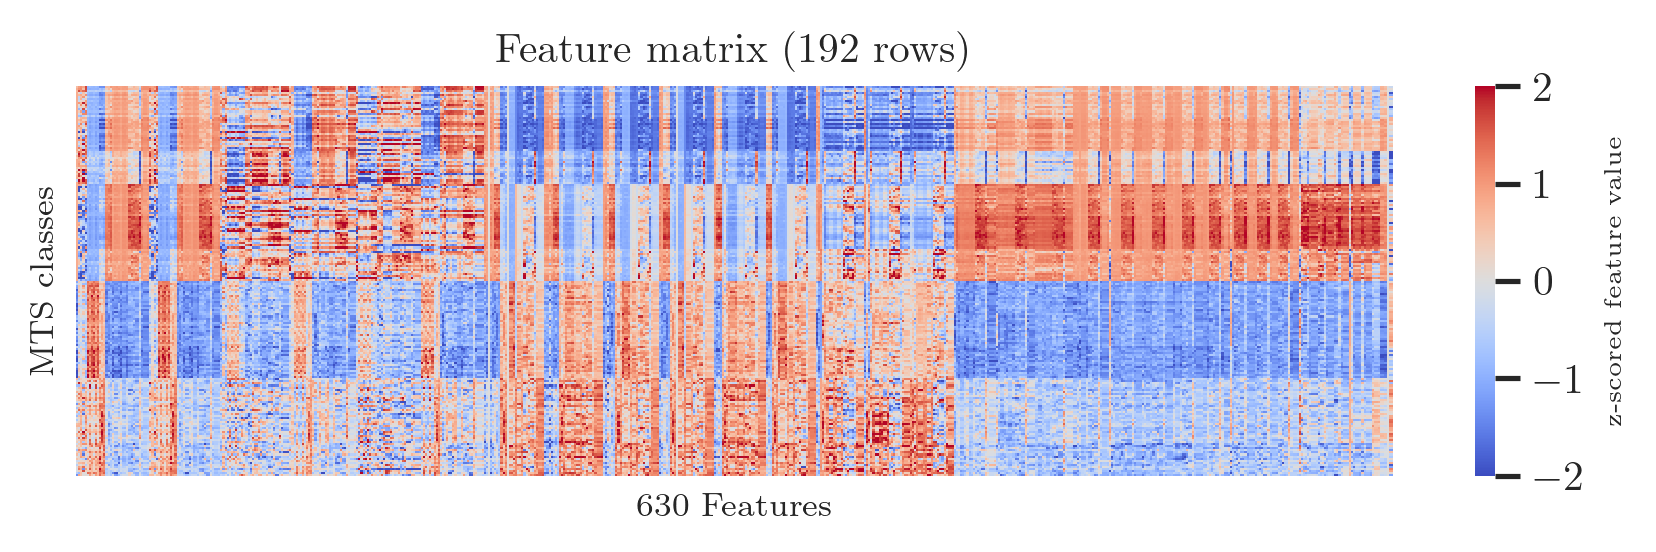

In [252]:
selected_classes = ["VAR(1)-Symmetric", "VAR(1)-Unidirectional"]  # leave [] for all

# Build mask (all True if no selection)
mask = meta_df["mts_class"].isin(selected_classes) if selected_classes else np.ones(len(meta_df), dtype=bool)
X_selected = X[mask]
meta_selected = meta_df[mask].reset_index(drop=True)

# Z-normalize each feature across the selected rows
col_means = X_selected.mean(axis=0)
col_stds = X_selected.std(axis=0)
col_stds[col_stds < 1e-9] = 1.0  # avoid div-by-zero
Xz = (X_selected - col_means) / col_stds

fig, ax = plt.subplots(figsize=(6, 2), dpi=300)
sns.heatmap(Xz, cmap="coolwarm", cbar=True, ax=ax, vmin=-2, vmax=2)
ax.collections[0].colorbar.set_label("z-scored feature value", fontsize=6)
ax.set_xlabel(f"{Xz.shape[1]} Features", fontsize=8)
ax.set_ylabel("MTS classes", fontsize=8)
ax.set_xticks([]); ax.set_yticks([])
ax.set_title(f"Feature matrix ({len(meta_selected)} rows)", fontsize=10)
plt.tight_layout()
plt.show()


##### **v1.2** - `case_3` - `test_features.py`

##### **v2** - `process_features.py`: creates pseudo-SPIs for directed statistics

In [236]:
import importlib
import process_features
importlib.reload(process_features)
from process_features import load_cached_features, load_samples_with_flags, build_feature_matrix
from process_features import _safe_zscore, _edge_vectors  # only if you still need them

def load_features(cache_path):
    data = np.load(cache_path, allow_pickle=True)
    X = data["X"]
    meta_df = pd.DataFrame({
        "mts_class": data["y"],
        "variant": data.get("variant", ""),
        "M": data.get("M", np.nan),
        "T": data.get("T", np.nan),
        "instance": data.get("instance", np.nan),
        "dataset_path": data.get("dataset_paths", [""] * len(data["y"])),
    })
    spi_order = list(data["spi_order"])
    pairs = list(data["pairs"])
    return X, meta_df, spi_order, pairs

In [245]:
cache_path = Path("analysis\\feature_cache\\features_data-full_spi_subset_common220.txt.npz")
X, meta_df, spi_order, pairs = load_features(cache_path)

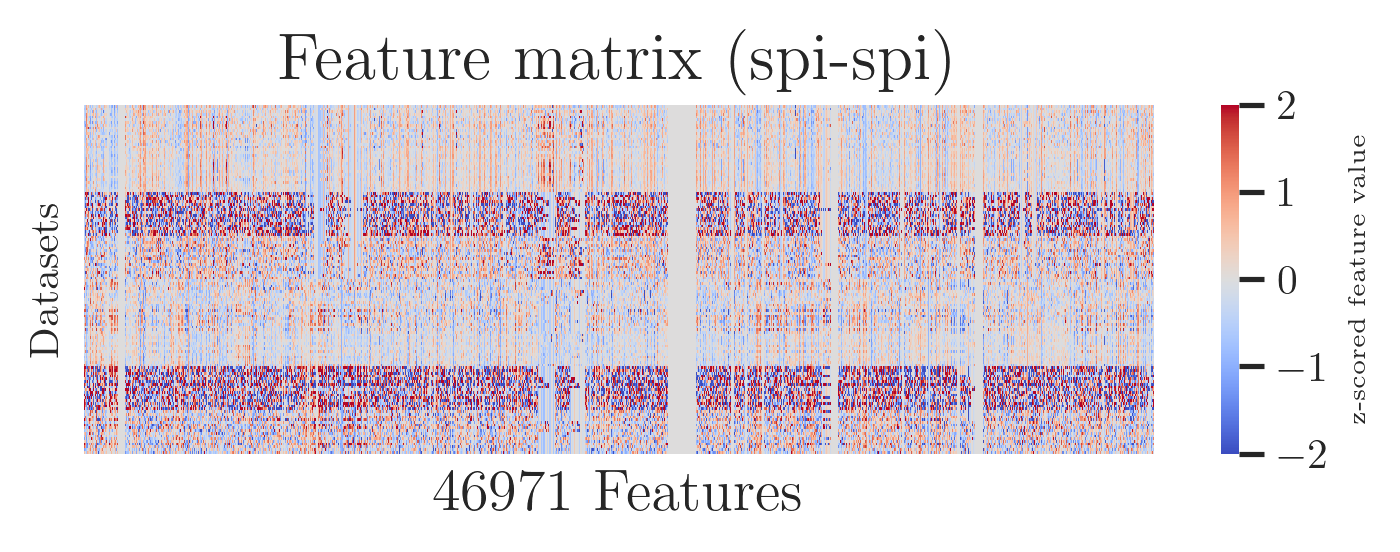

In [246]:
selected_classes = ["CML", "CauchyNoise"] # specify desired classes or leave empty for all
noise_mask = meta_df["mts_class"].isin(selected_classes)
X_selected = X[noise_mask] if selected_classes else X            
meta_selected = meta_df[noise_mask]   

# Z-normalize each feature (column) across the selected noise datasets
col_means = X_selected.mean(axis=0)
col_stds = X_selected.std(axis=0)
Xz = (X_selected - col_means) / (col_stds + 1e-9)  # avoid div-by-zero

fig, ax = plt.subplots(figsize=(5, 2), dpi=300)
sns.heatmap(Xz, cmap="coolwarm", cbar=True, ax=ax, vmin=-2, vmax=2)  #cbar_kws={"shrink": 0.8},
ax.collections[0].colorbar.set_label("z-scored feature value", fontsize=6)
ax.set_xlabel(f"{Xz.shape[1]} Features")
ax.set_ylabel("Datasets", fontsize=10)
ax.set_xticklabels(""), ax.set_yticklabels("")
ax.set_xticks([]), ax.set_yticks([])
ax.set_title(f"Feature matrix (spi-spi)")
plt.tight_layout()
plt.show()

In [41]:
import numpy as np, itertools, collections
data = np.load("analysis/feature_cache/features_full_limit40.npz", allow_pickle=True)
pairs = list(data["pairs"])
print("feature count", len(pairs))
uniq = set(itertools.chain.from_iterable(pairs))
print("pseudo-SPI count", len(uniq))
print("first 10 pseudo-SPIs:", list(itertools.islice(uniq, 10)))
# count directed splits vs undirected
c = collections.Counter(name.split("__")[0] for name in uniq)
print("top SPI bases:", c.most_common(10))


feature count 51360
pseudo-SPI count 321
first 10 pseudo-SPIs: ['xme_kernel_W-0.5_k1__ji', 'di_gaussian__ij', 'gpdcoh_multitaper_max_fs-1_fmin-0_fmax-0-25__ji', 'prec-sq_LedoitWolf', 'cohmag_multitaper_max_fs-1_fmin-0-25_fmax-0-5', 'spearmanr', 'hsic', 'icoh_multitaper_mean_fs-1_fmin-0_fmax-0-25', 'dswpli_multitaper_mean_fs-1_fmin-0_fmax-0-5', 'di_gaussian__ji']
top SPI bases: [('xme_kernel_W-0.5_k1', 2), ('di_gaussian', 2), ('gpdcoh_multitaper_max_fs-1_fmin-0_fmax-0-25', 2), ('ddtf_multitaper_max_fs-1_fmin-0_fmax-0-5', 2), ('dcoh_multitaper_mean_fs-1_fmin-0_fmax-0-25', 2), ('xme_kernel_W-0.5_k10', 2), ('dcoh_multitaper_mean_fs-1_fmin-0-25_fmax-0-5', 2), ('ddtf_multitaper_mean_fs-1_fmin-0-25_fmax-0-5', 2), ('anm', 2), ('di_kernel_W-0.5', 2)]


#### **Low-dimensional embeddings:** PCA, UMAP, t-SNE

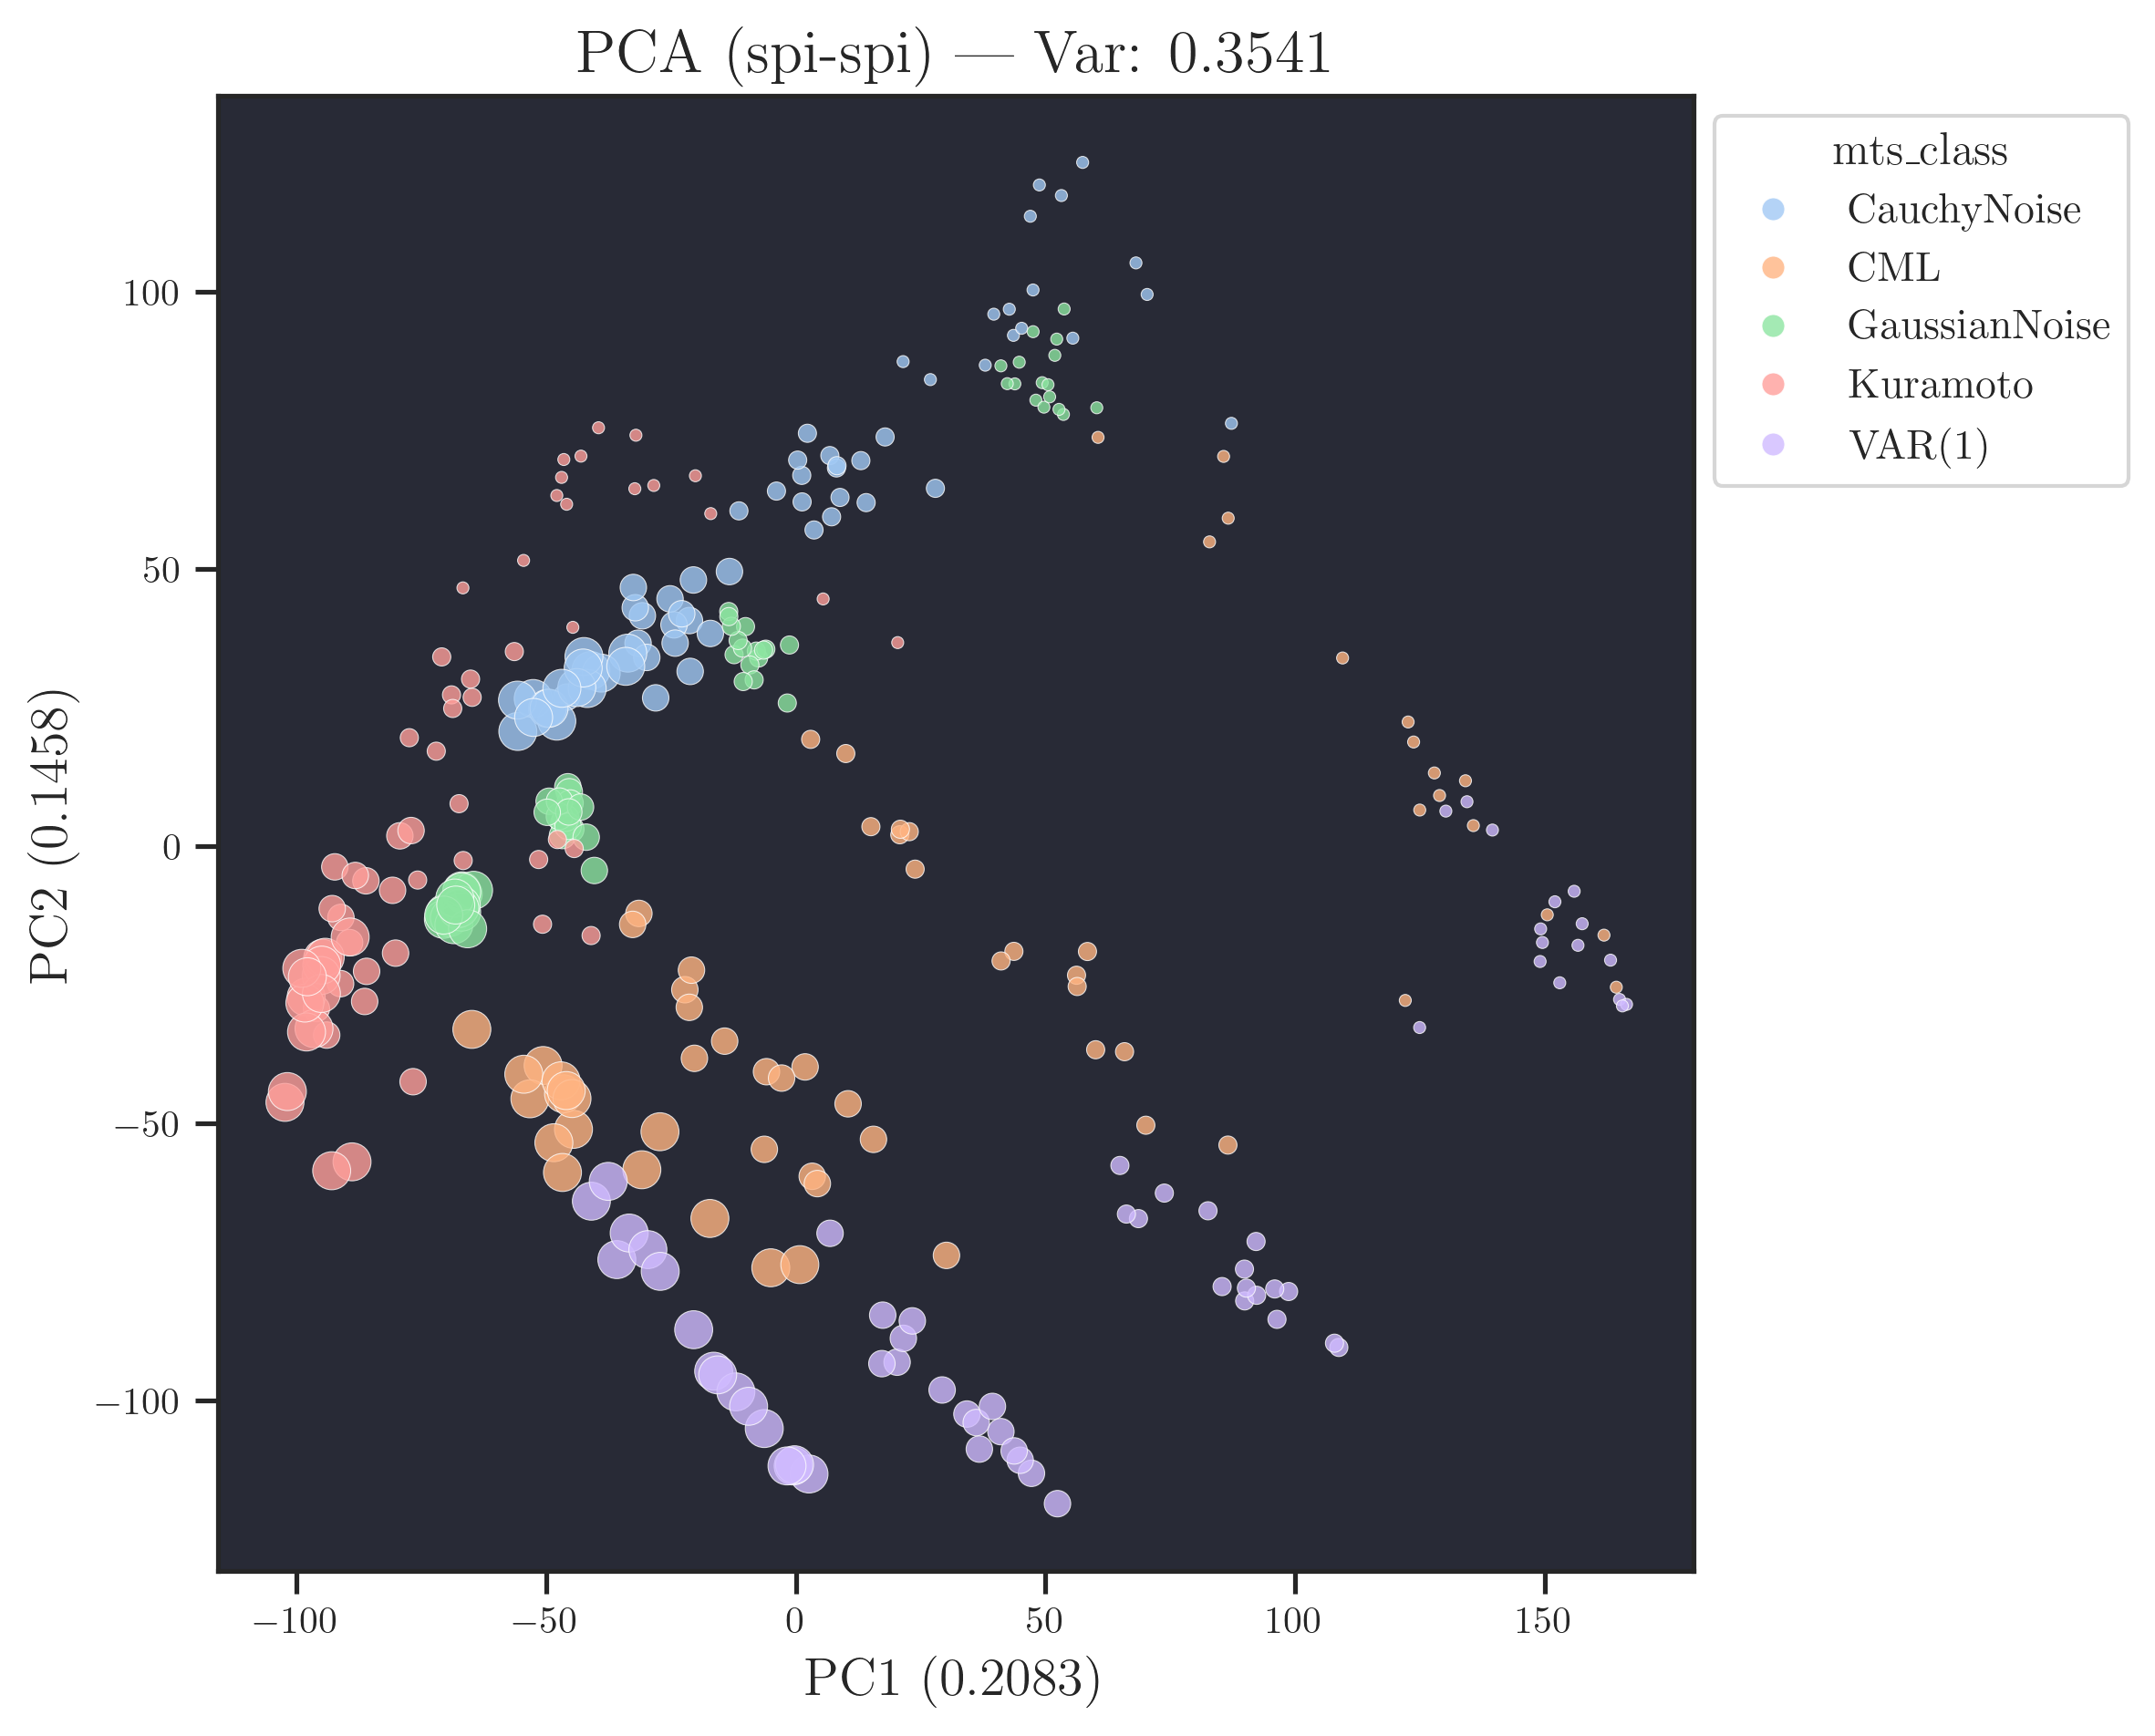

c:\Users\wille\OneDrive\Desktop\2025USYD\USYD\mts-spi-study-cluster\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(min_dist=0.55, n_jobs=1, n_neighbors=6, random_state=0, verbose=True)
Tue Dec  9 12:34:08 2025 Construct fuzzy simplicial set
Tue Dec  9 12:34:09 2025 Finding Nearest Neighbors
Tue Dec  9 12:34:09 2025 Finished Nearest Neighbor Search
Tue Dec  9 12:34:09 2025 Construct embedding


Epochs completed:  25%| ██▌        127/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs


Epochs completed:  53%| █████▎     266/500 [00:00]

	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs


Epochs completed:  93%| █████████▎ 463/500 [00:00]

	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:00]


Tue Dec  9 12:34:10 2025 Finished embedding


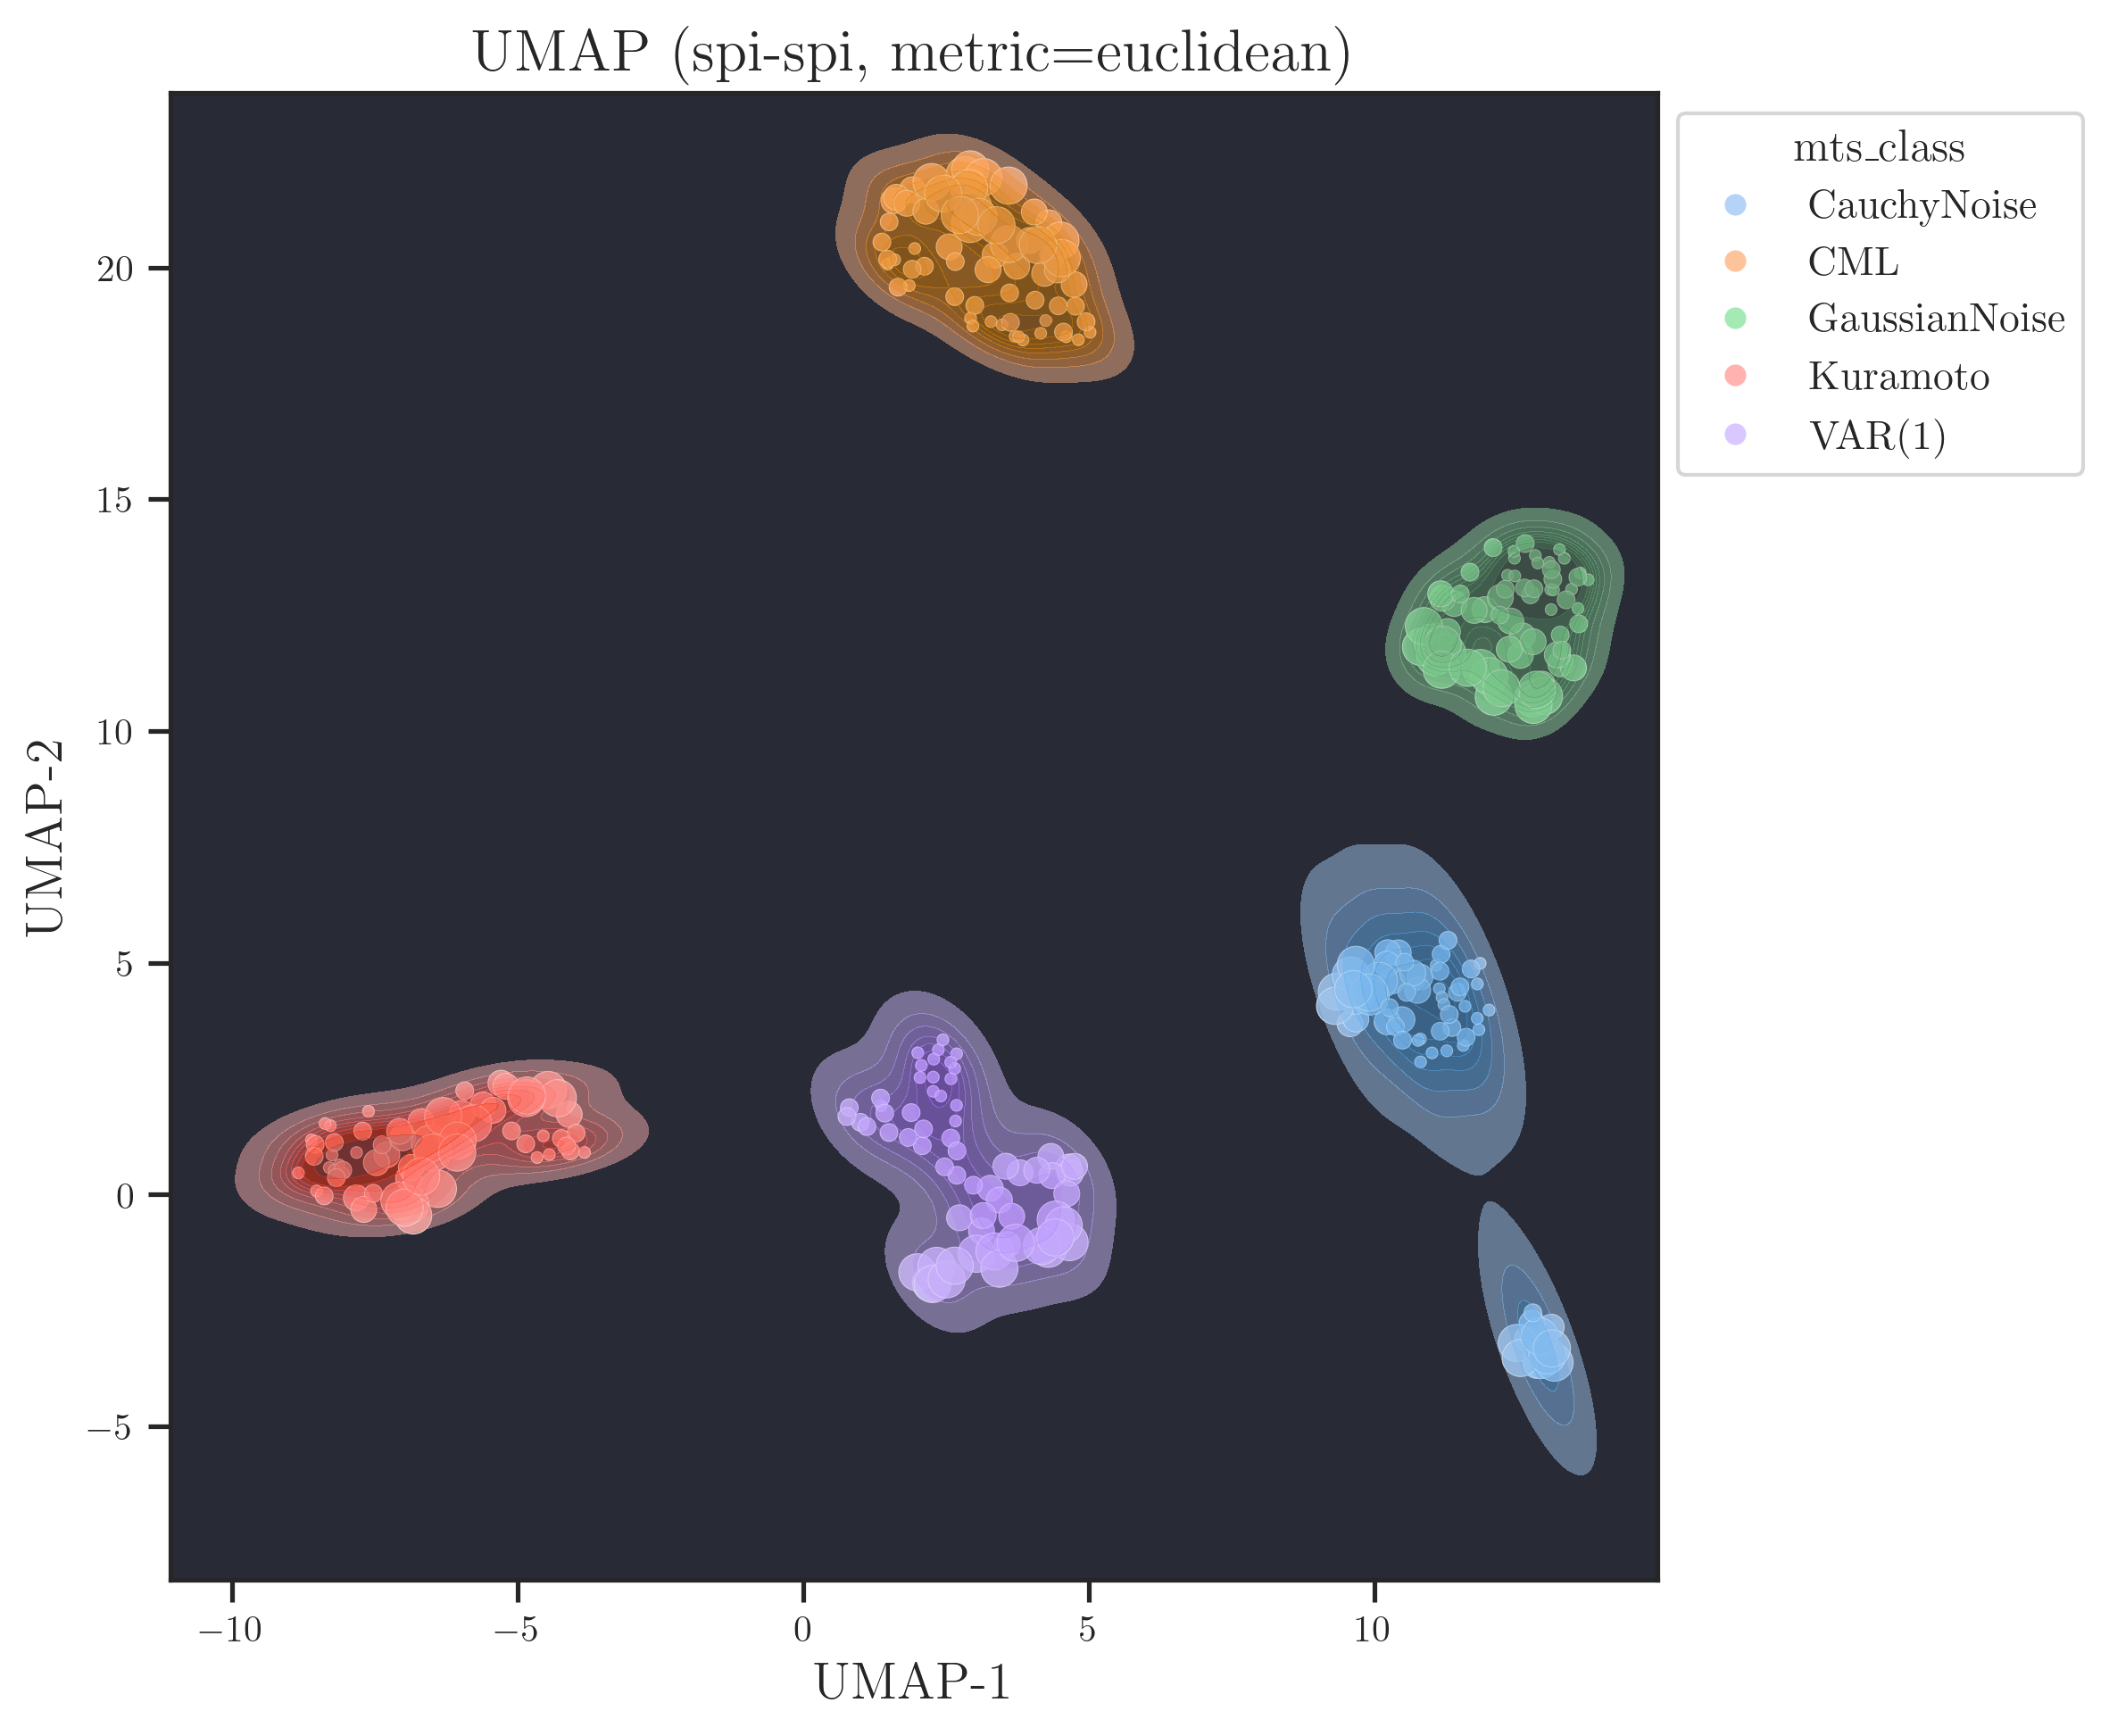

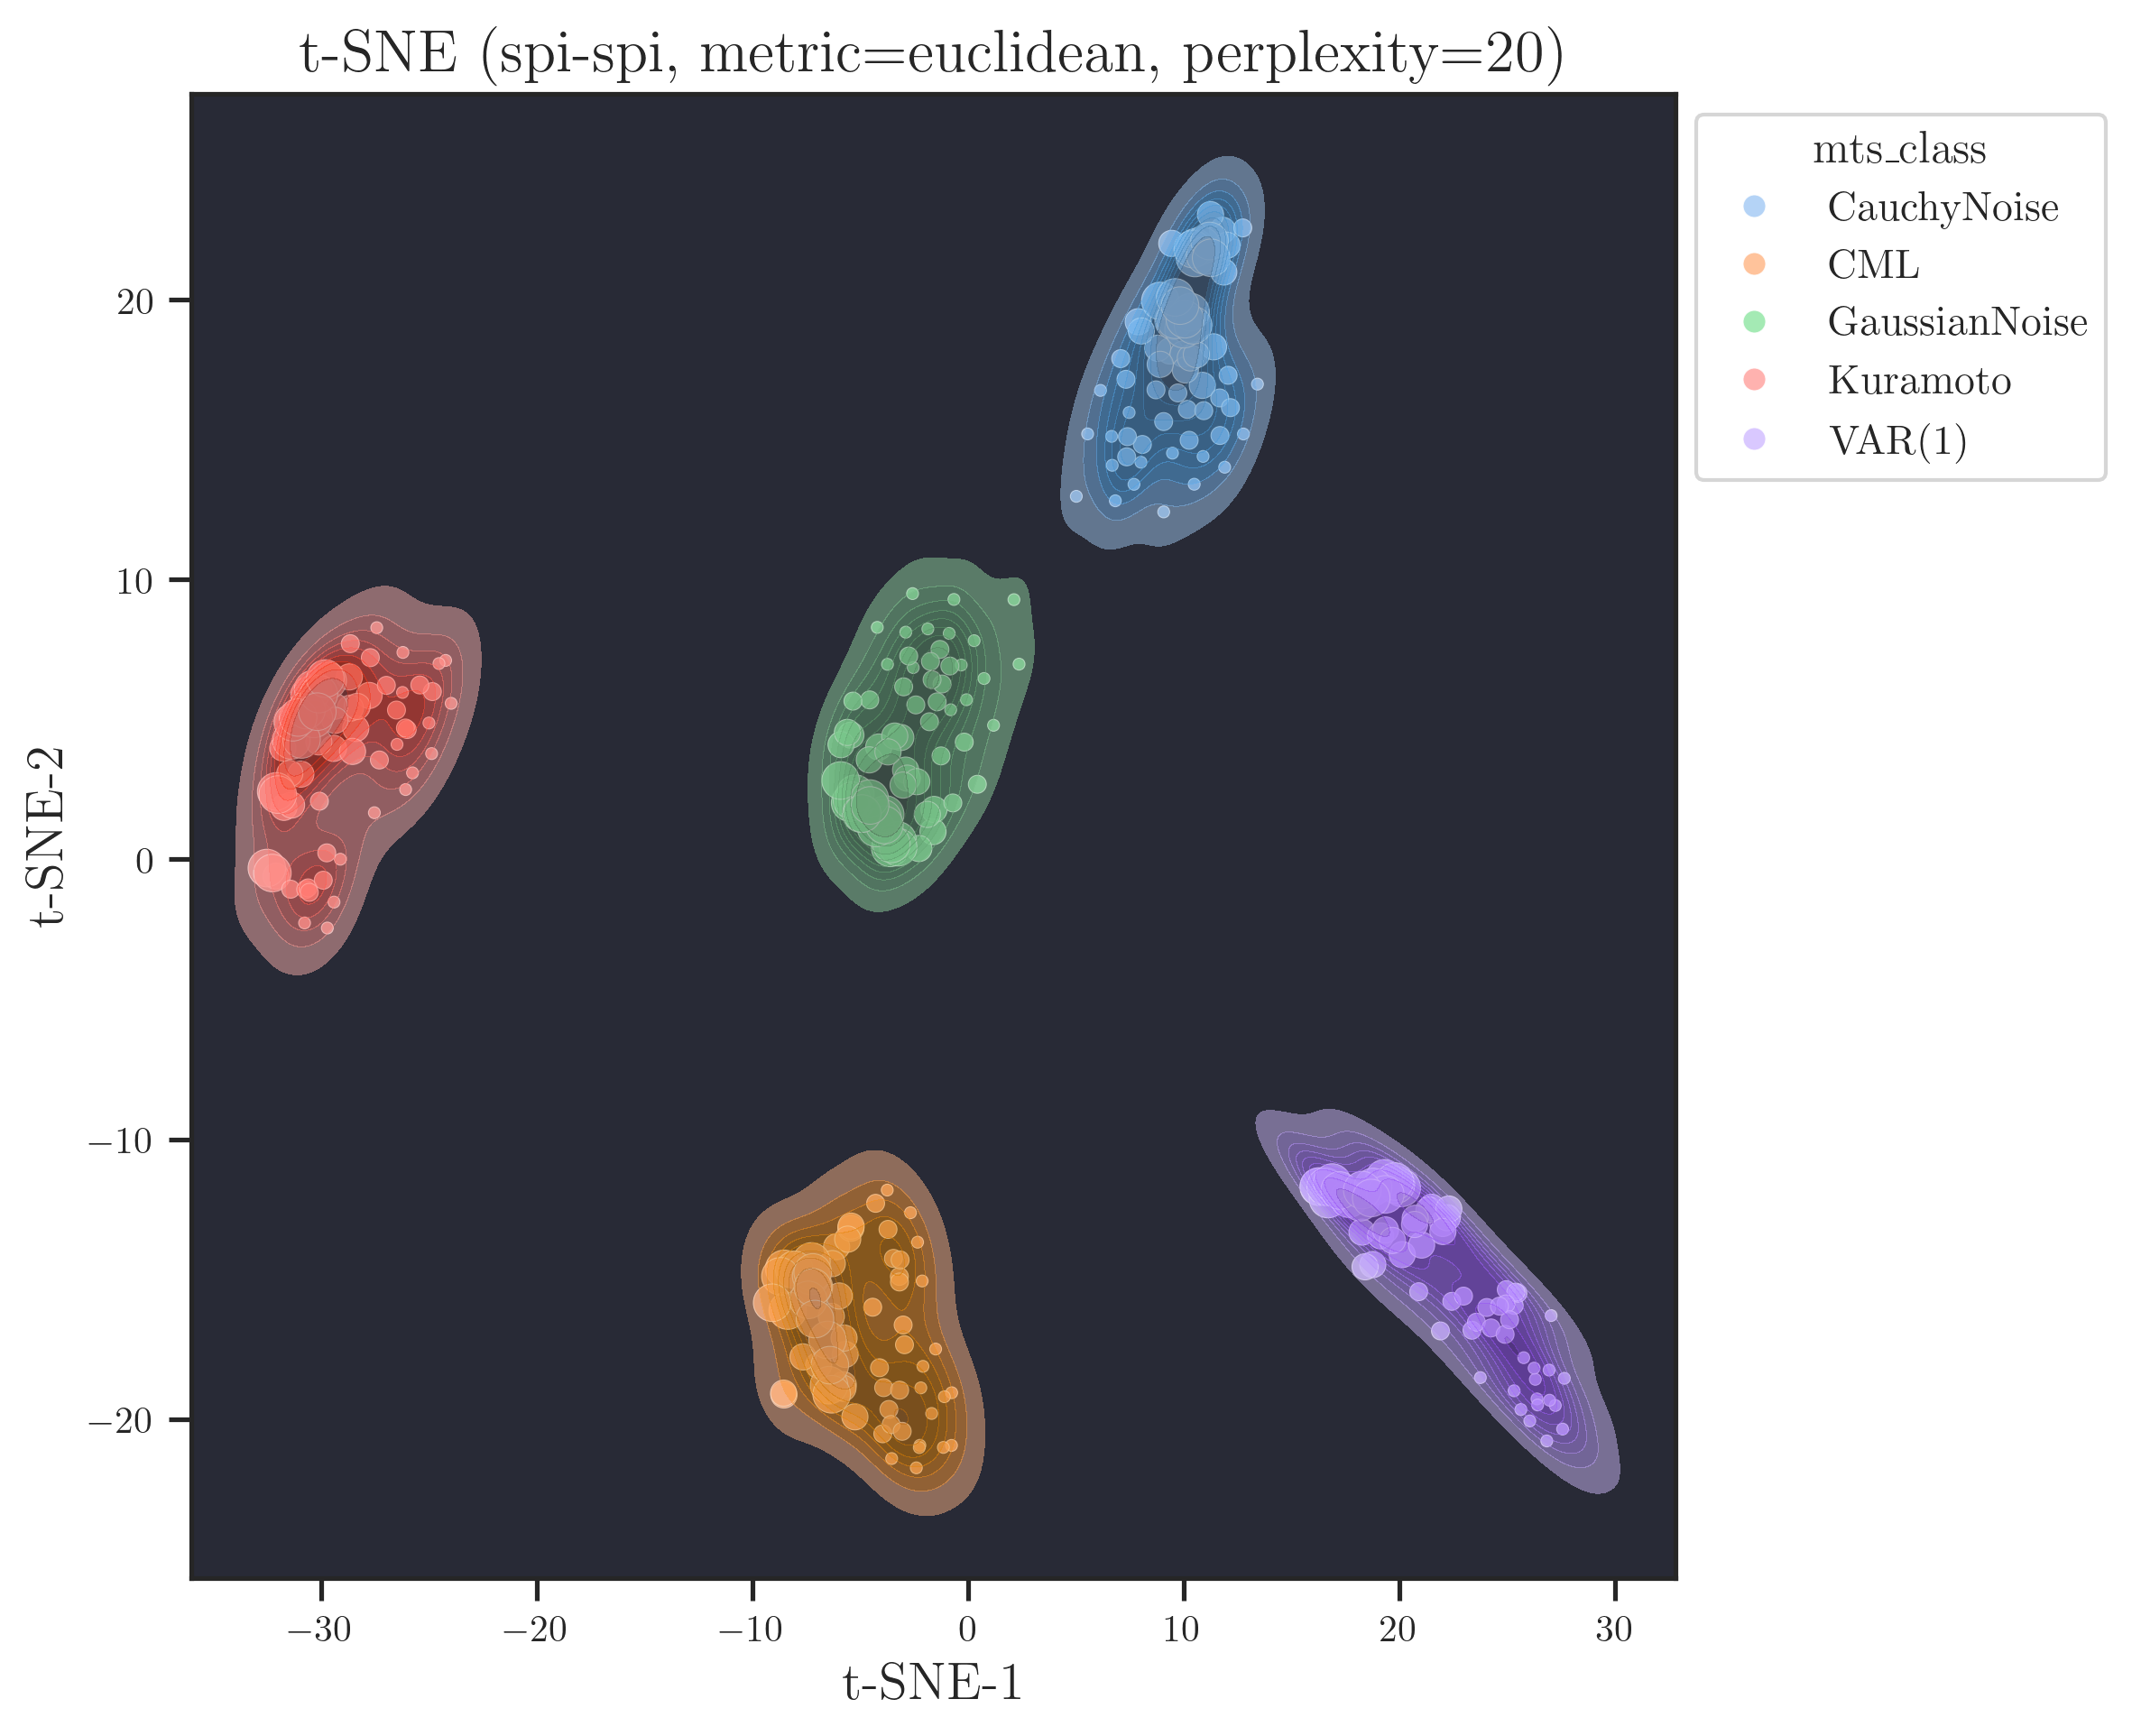

In [233]:
import importlib
import src.visualization
importlib.reload(src.visualization)
from src.visualization import plot_pca, plot_umap, plot_tsne

# Common kwargs for all plots
common_kwargs = dict(
    feature_space=f"spi-spi",
    hue="mts_class",
    size_col="M",
    sizes=(10, 100),
    random_state=0,
    facecolor="#282a36" 
)


# embedding_pca = plot_pca(X, meta_df, **common_kwargs)
# embedding_umap = plot_umap(X, meta_df, metric="euclidean", n_neighbors=6, min_dist=0.55,**common_kwargs)
# embedding_tsne = plot_tsne(X, meta_df, metric="euclidean", perplexity=5, **common_kwargs)

embedding_pca = plot_pca(X_selected, meta_selected, **common_kwargs)
embedding_umap = plot_umap(X_selected, meta_selected, metric="euclidean", n_neighbors=6, min_dist=0.55,**common_kwargs)
embedding_tsne = plot_tsne(X_selected, meta_selected, metric="euclidean", perplexity=20, **common_kwargs)

### UMAP, t-SNE

### MPIs, SPI-SPI feature_space 

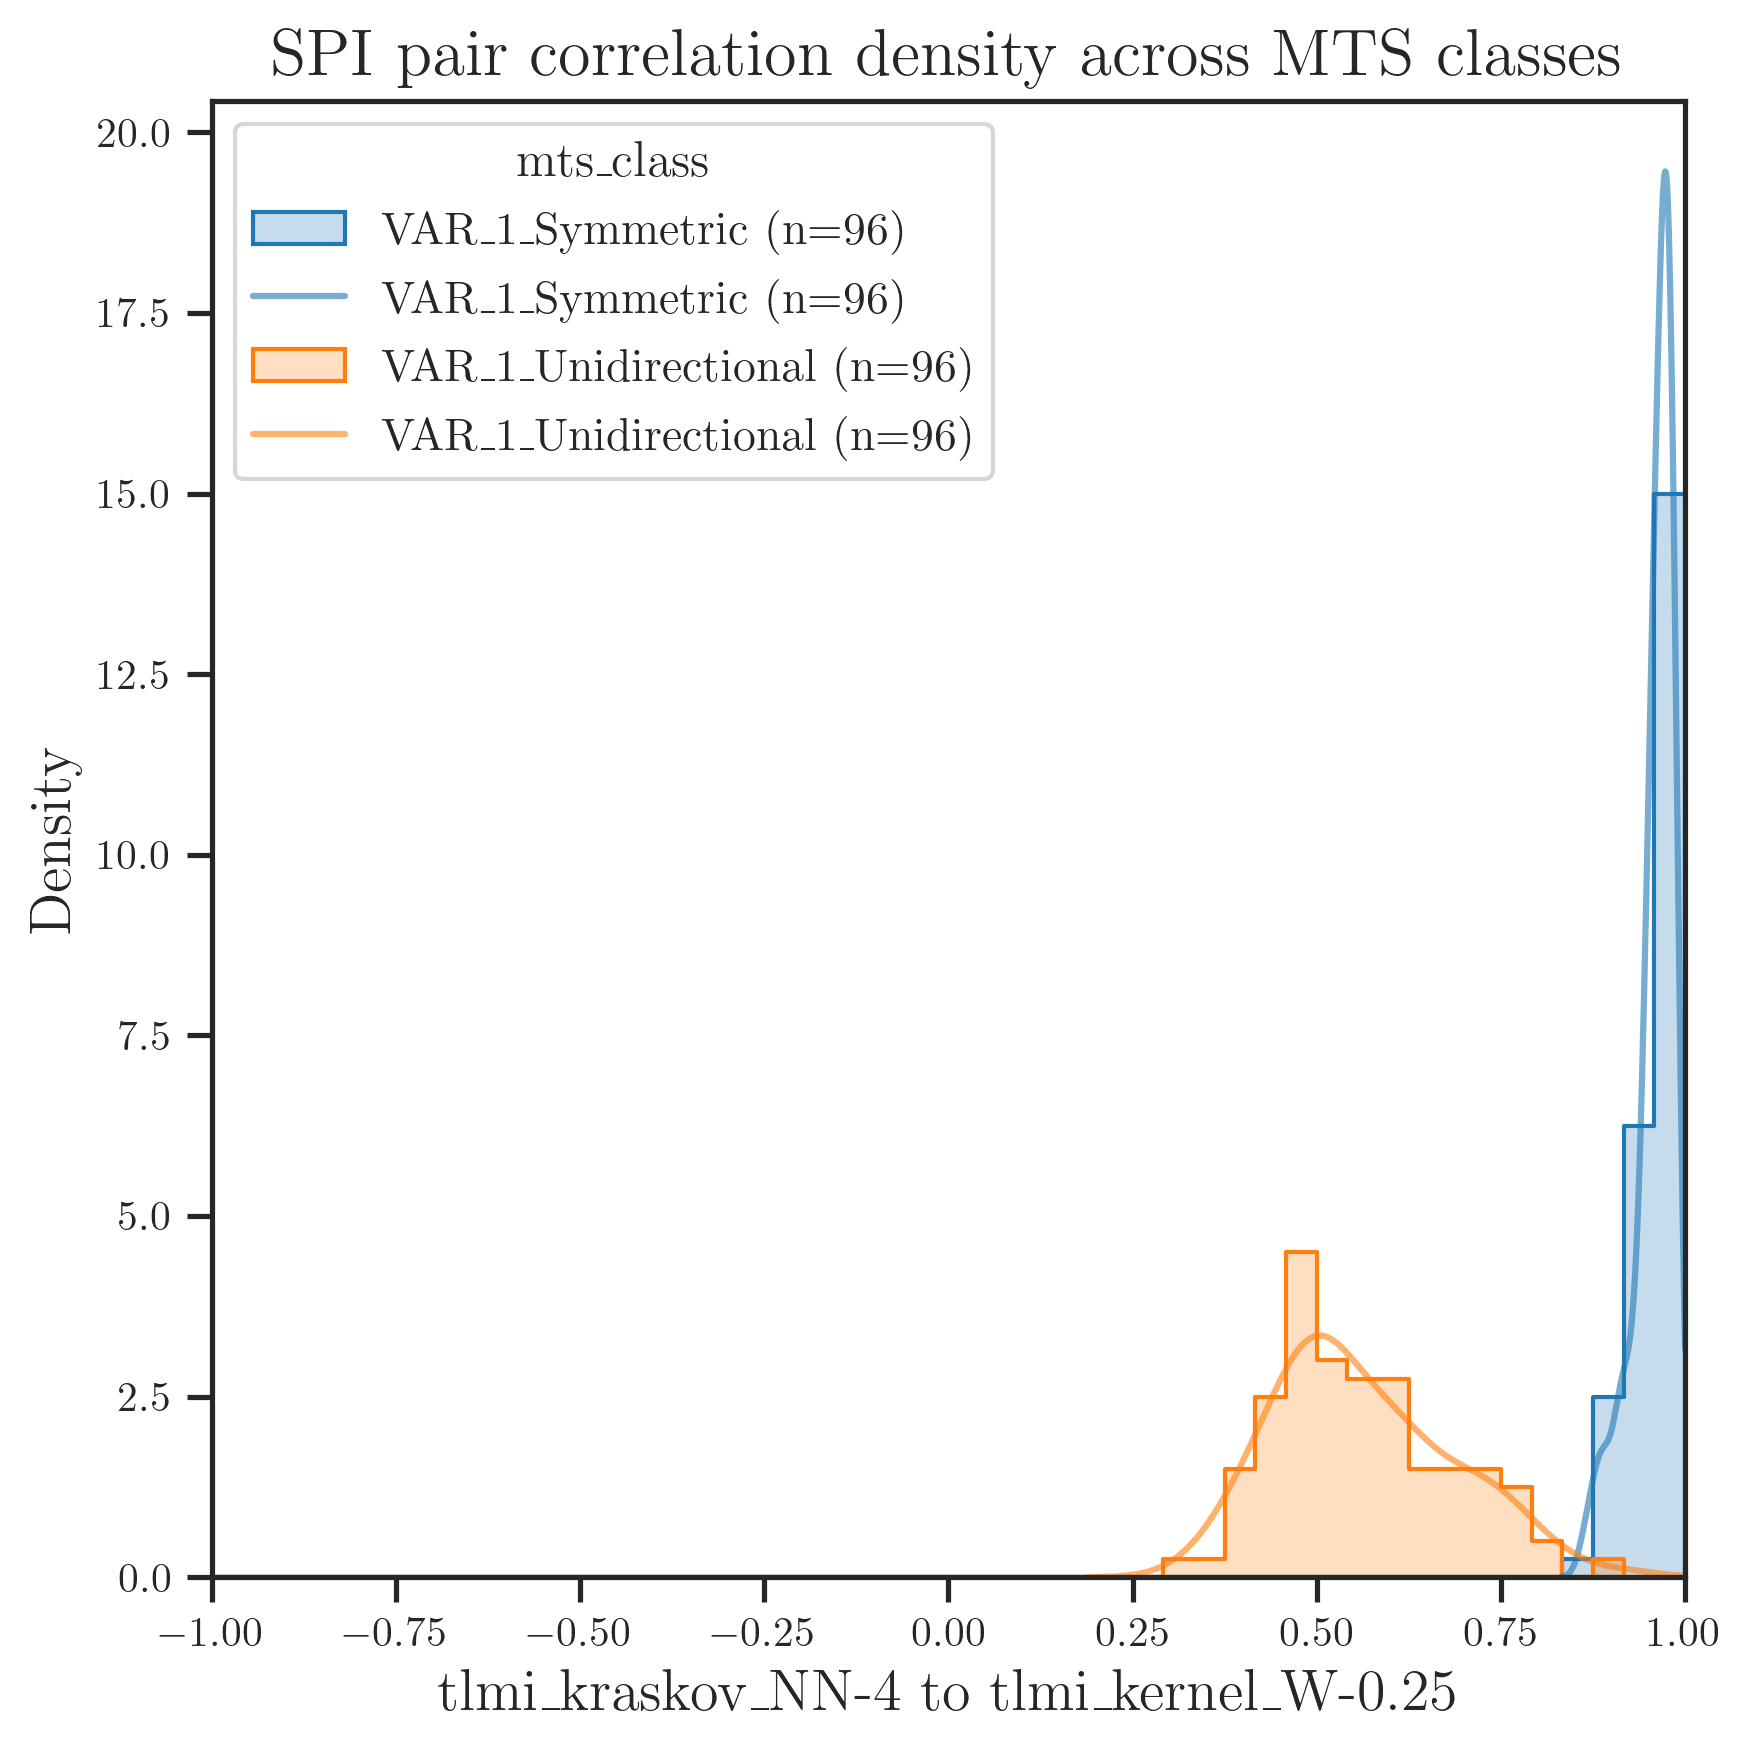

In [ ]:
importlib.reload(src.visualization)
from src.visualization import plot_spi_space_individual, plot_mts_corr_density


plot_mts_corr_density(
    ["data/case_2/VAR_1_Symmetric", "data/case_2/VAR_1_Unidirectional"],
    # ["di_gaussian", "igci"],
    # ["cov-sq_GraphicalLasso", "di_gaussian"],
    # ["cce_kozachenko", "di_gaussian"],
    # ["mi_kernel_W-0.25", "tlmi_kraskov_NN-4"],
    # ["mi_kraskov_NN-4", "spearmanr"],
    # ["mi_kraskov_NN-4", "te_symbolic_k-1_kt-1_l-1_lt-1"],
    # ["mi_kraskov_NN-4", "gc_gaussian_k-1_kt-1_l-1_lt-1"],
    bw_adjust=1.0,  # optional KDE bandwidth tweak
    bins=48
)


###### Unused stuff from before (individual SPI-SPI space plots)

In [ ]:
importlib.reload(src.visualization)
from src.visualization import plot_mpi_heatmap, plot_spi_space_individual
plot_spi_space_individual(dataset_path="data\\full-variants\\VAR_1_variants\\M32_T1600_I0_phi-0-9-coupling-0-1",
    # spis=["spearmanr", "cov_EmpiricalCovariance"])
    spis=["mi_kraskov_NN-4", "te_kraskov_NN-4_DCE_k-1_kt-1_l-1_lt-1"])
plot_spi_space_individual(dataset_path="data\\full-variants\\VAR_1_variants\\M32_T1600_I0_phi-0-1-coupling-0-9",
    # spis=["spearmanr", "cov_EmpiricalCovariance"])
    spis=["mi_kraskov_NN-4", "te_kraskov_NN-4_DCE_k-1_kt-1_l-1_lt-1"])

plot_mpi_heatmap(
                "VAR_1", "M16_T1600_I0_phi-0-99",
                # "CML", "M25_T1600_I0_alpha1p7522-eps0p00115_spatiotemporal-intermittency-i",
                # "Kuramoto", "M16_T1600_I0_grid-four-k--4_grid-four",
                 ["cov_EmpiricalCovariance", "spearmanr", "xcorr_max_sig-True", 
                  "mi_kraskov_NN-4", "di_gaussian", "ce_gaussian", 
                  "te_kraskov_NN-4_DCE_k-1_kt-1_l-1_lt-1", "gc_gaussian_k-1_kt-1_l-1_lt-1", "cce_gaussian",
                  "di_gaussian",
                  "pdist_cosine", "pdist_canberra", "pdist_euclidean"
                  ])
# Automatically picks symmetric scales for cov/corr, non-negative for info/distance SPIs.


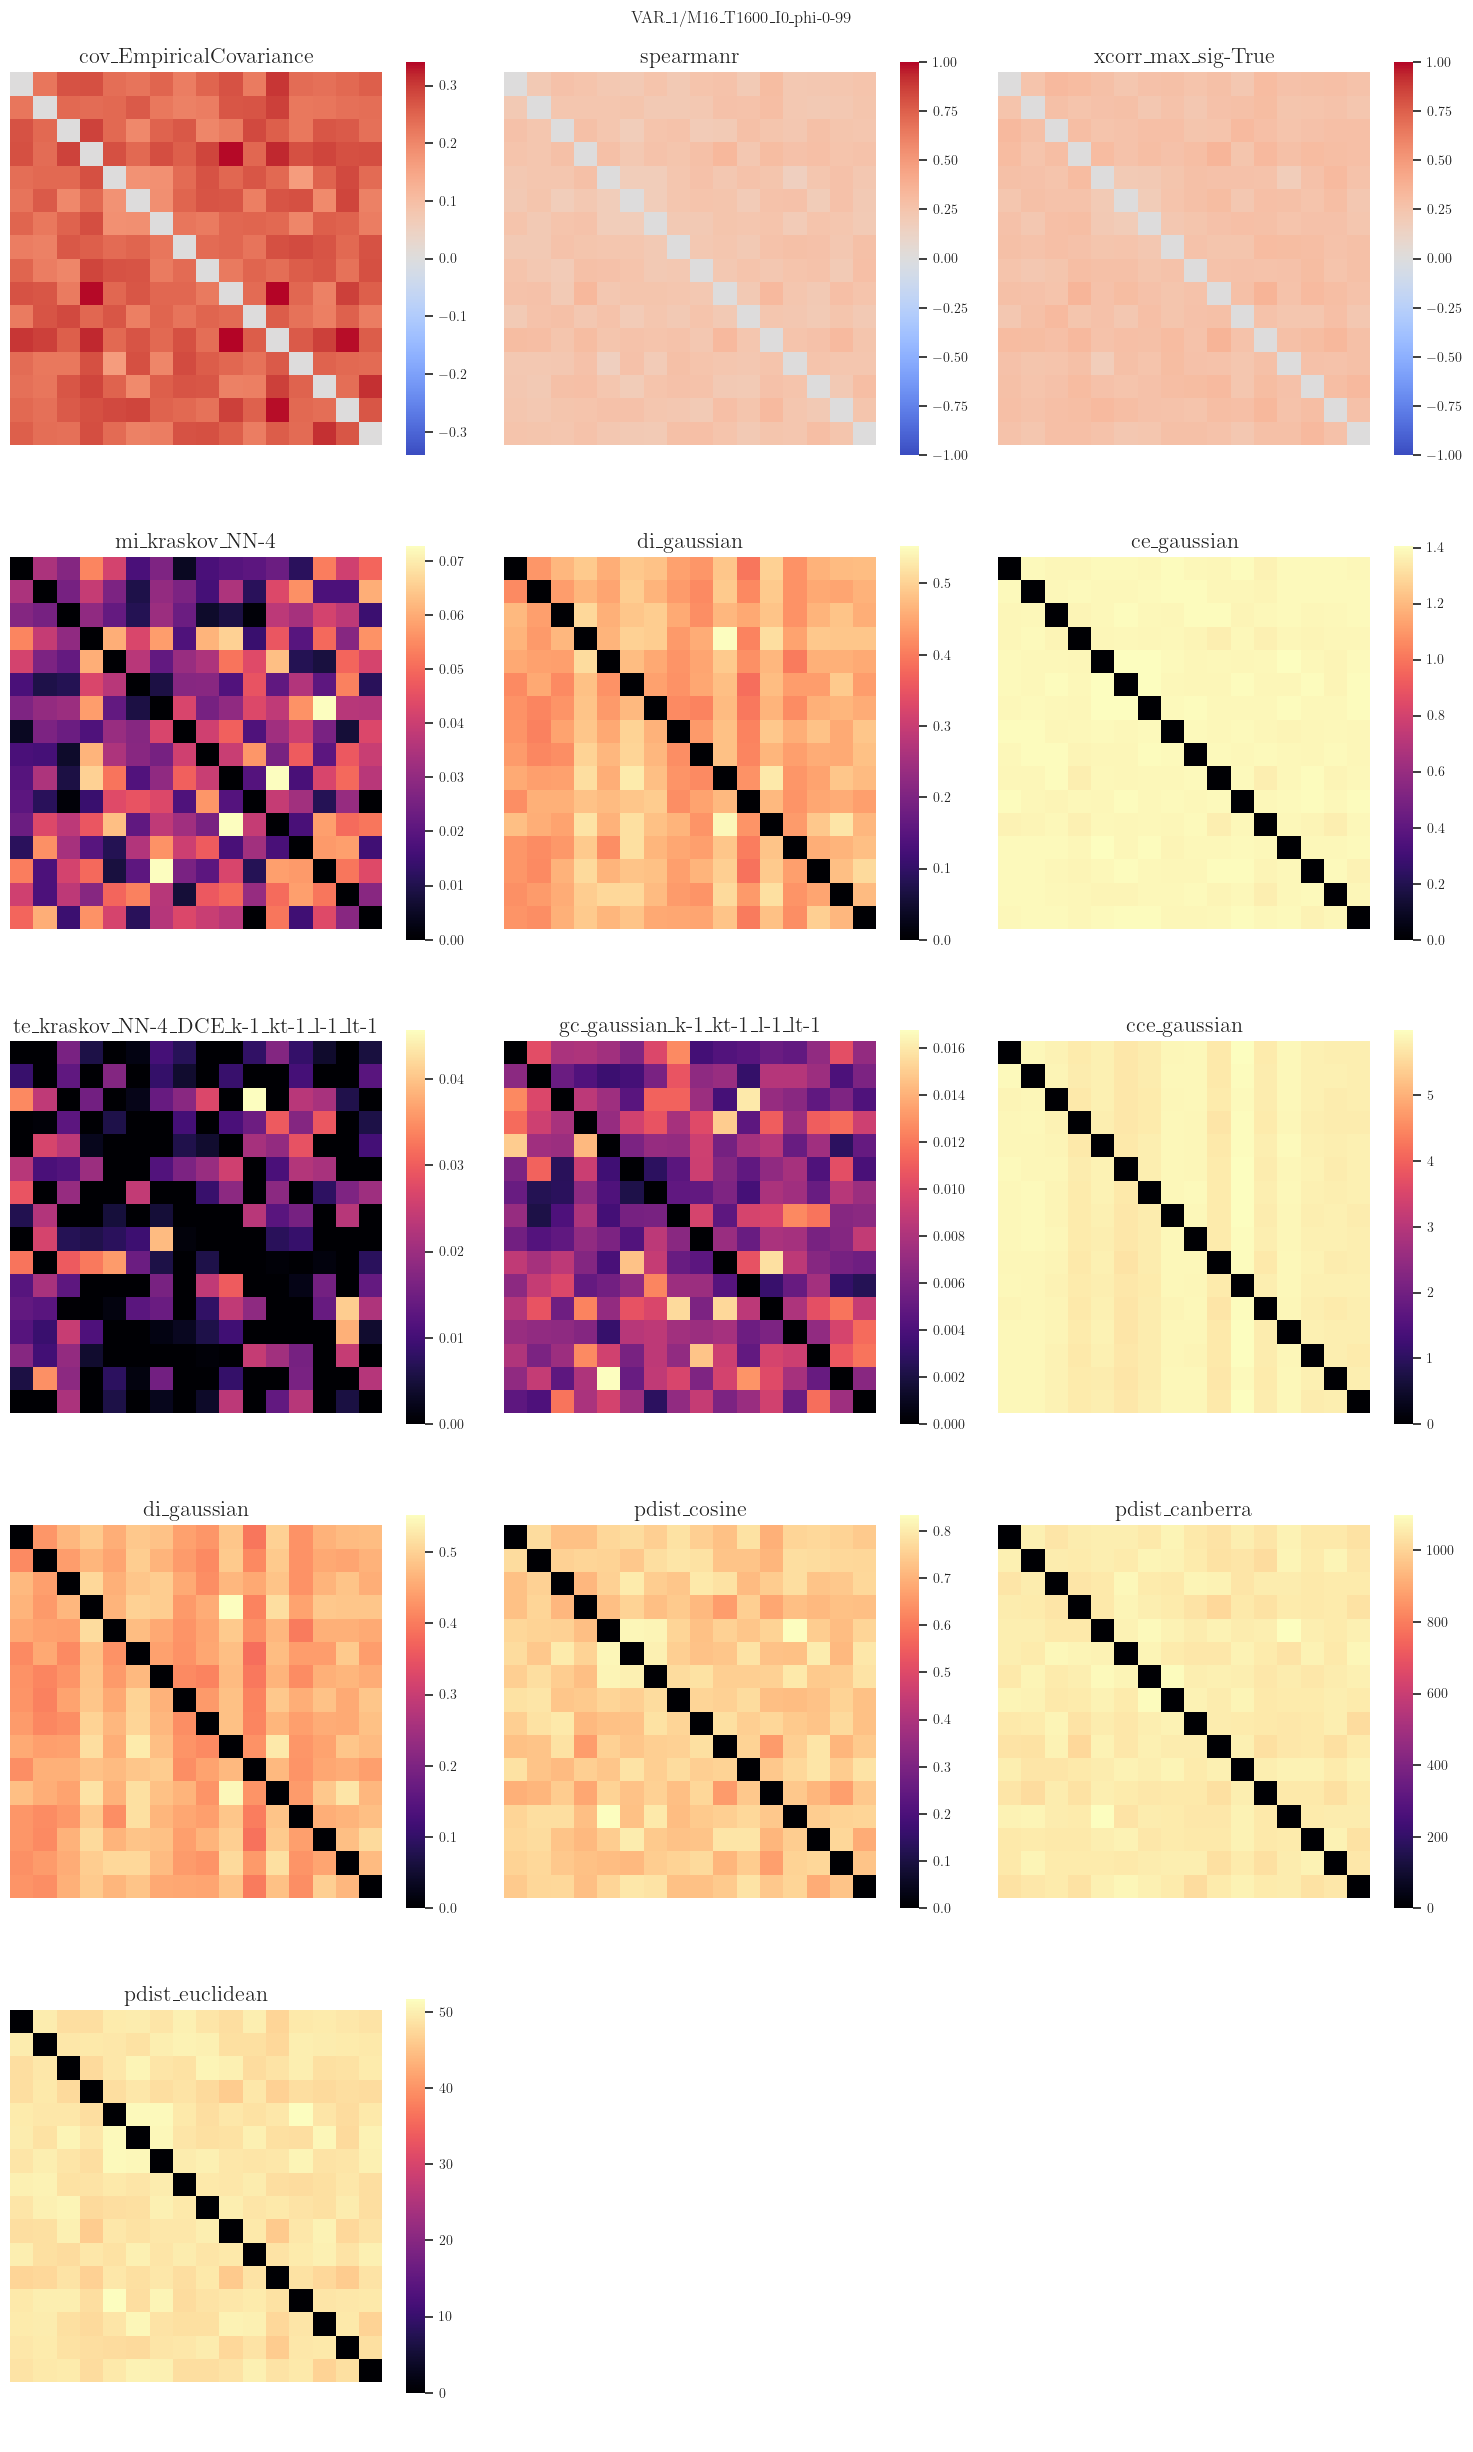